# Import Libraries


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

# Global Variables

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

# Load data into tf.dataset

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory( 
    "Dataset", 
    shuffle=True, 
    image_size = (IMAGE_SIZE,IMAGE_SIZE), 
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

# Data visualization

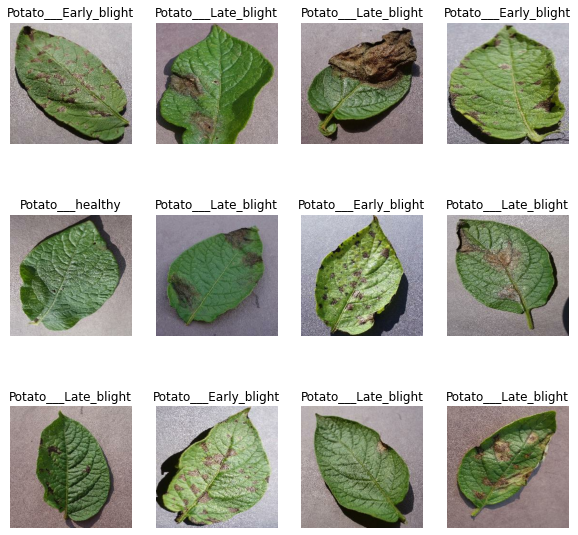

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Train test split

80% ==> training
20% ==> 10% validation, 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54) 
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# CNN Model Building and Training

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
54/54 [==============================] - 44s 430ms/step - loss: 0.8867 - accuracy: 0.5185 - val_loss: 0.7390 - val_accuracy: 0.6406
Epoch 2/100
54/54 [==============================] - 12s 229ms/step - loss: 0.6330 - accuracy: 0.7193 - val_loss: 0.4977 - val_accuracy: 0.7917
Epoch 3/100
54/54 [==============================] - 10s 189ms/step - loss: 0.4043 - accuracy: 0.8385 - val_loss: 0.3000 - val_accuracy: 0.8958
Epoch 4/100
54/54 [==============================] - 10s 187ms/step - loss: 0.3156 - accuracy: 0.8652 - val_loss: 0.4781 - val_accuracy: 0.8073
Epoch 5/100
54/54 [==============================] - 11s 213ms/step - loss: 0.3082 - accuracy: 0.8762 - val_loss: 0.2735 - val_accuracy: 0.9010
Epoch 6/100
54/54 [==============================] - 11s 203ms/step - loss: 0.2406 - accuracy: 0.9062 - val_loss: 0.1922 - val_accuracy: 0.9167
Epoch 7/100
54/54 [==============================] - 10s 193ms/step - loss: 0.3134 - accuracy: 0.8762 - val_loss: 0.2651 - val_accuracy:

54/54 [==============================] - 10s 189ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.2405 - val_accuracy: 0.9062
Epoch 58/100
54/54 [==============================] - 10s 191ms/step - loss: 0.0216 - accuracy: 0.9942 - val_loss: 0.0927 - val_accuracy: 0.9844
Epoch 59/100
54/54 [==============================] - 10s 188ms/step - loss: 0.0082 - accuracy: 0.9965 - val_loss: 0.0797 - val_accuracy: 0.9896
Epoch 60/100
54/54 [==============================] - 10s 186ms/step - loss: 0.0170 - accuracy: 0.9948 - val_loss: 0.0498 - val_accuracy: 0.9792
Epoch 61/100
54/54 [==============================] - 10s 190ms/step - loss: 0.0457 - accuracy: 0.9844 - val_loss: 0.0486 - val_accuracy: 0.9896
Epoch 62/100
54/54 [==============================] - 10s 189ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0520 - val_accuracy: 0.9844
Epoch 63/100
54/54 [==============================] - 10s 185ms/step - loss: 0.0106 - accuracy: 0.9954 - val_loss: 0.0052 - val_accuracy: 0.994

# Plot Training History on Graph

In [23]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 106ms/step - loss: 0.0115 - accuracy: 0.9961


In [24]:
scores

[0.011510559357702732, 0.99609375]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
len(history.history['accuracy'])

100

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

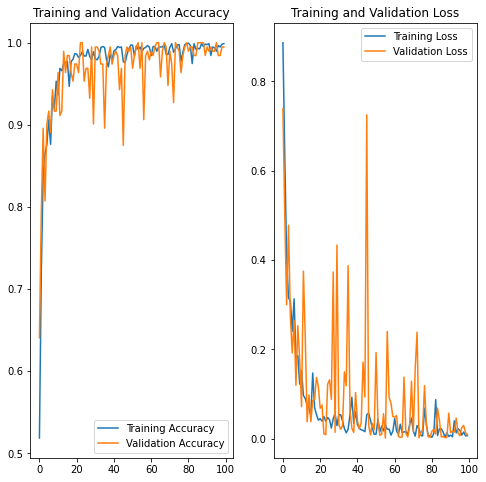

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction with Several Sample

first image to predict
first image's actual label: Potato___Late_blight
1/1 [==============================] - 1s 626ms/step
predicted label: Potato___Late_blight


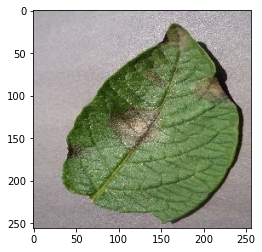

In [31]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


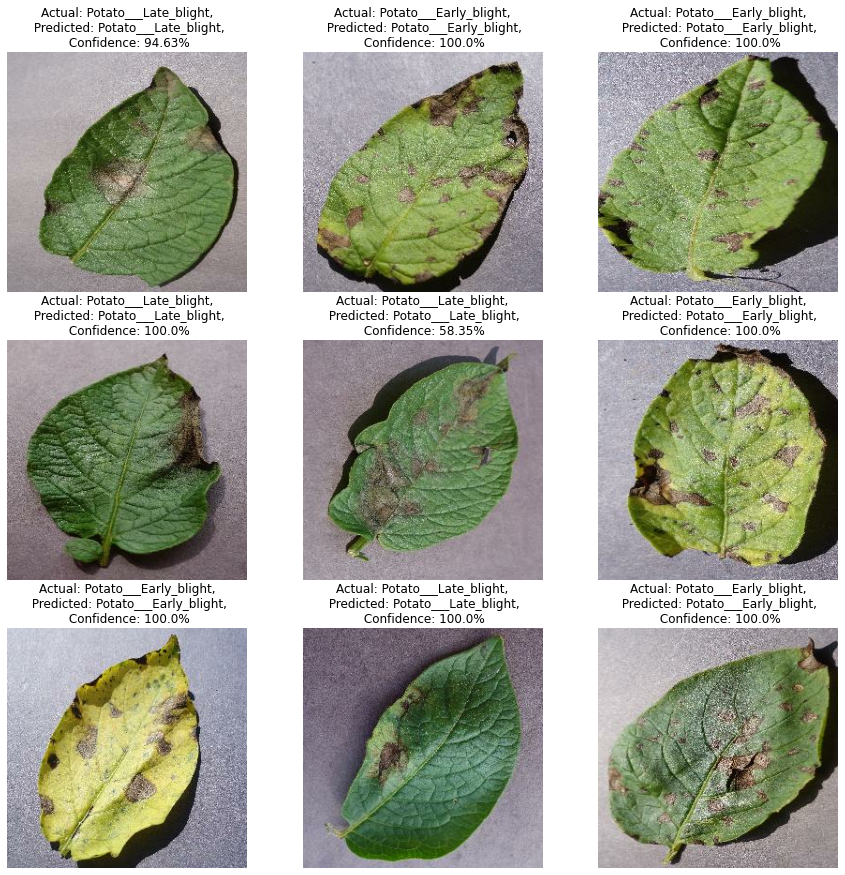

In [38]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        
        plt.axis("off")

# Exporting the model

In [34]:
model_version=max([int (i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets
